In [1]:
import numpy as np
import netCDF4 as nc
import datetime as dt
import copy
from scipy import stats
import esmpy as ESMF
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.path import Path
import matplotlib.dates as pltd
import matplotlib.patches as mpatches
experiment = "no_bias_correction"
start_year = 1960

In [2]:
def convert_nep_time(time):
    ref = dt.datetime(start_year,1,1,0,0,0)
    date_vals = np.zeros(len(time))
    for nt in range(len(time)):
        day_time = ref + dt.timedelta(days=float(time[nt]))
        date_vals[nt] = pltd.date2num(day_time)
            
    return date_vals

In [3]:
def create_regrid_obj(src_clon,src_clat,src_lsm,dst_clon,dst_clat):
    # Make 2D coordinates for remapping
    if len(src_clon.shape)<2:
        src_clon,src_clat = np.meshgrid(src_clon,src_clat)
        
    if len(dst_clon.shape)<2:
        dst_clon,dst_clat = np.meshgrid(dst_clon,dst_clat)
    
    sourcegrid = ESMF.Grid(np.array(src_lsm.shape), staggerloc = ESMF.StaggerLoc.CORNER,coord_sys = ESMF.CoordSys.SPH_DEG)
    sourcegrid.add_item(ESMF.GridItem.MASK,[ESMF.StaggerLoc.CENTER])
    grid_mask = sourcegrid.get_item(ESMF.GridItem.MASK)
    grid_mask[...] = src_lsm.astype(np.int32) 

    source_lon = sourcegrid.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    source_lat = sourcegrid.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)

    source_lon[...] = src_clon
    source_lat[...] = src_clat

    sourcefield = ESMF.Field(sourcegrid, name = 'src_field')
    srcfracfield = ESMF.Field(sourcegrid, 'srcfracfield')
        
    destgrid = ESMF.Grid(np.array(dst_clon[1:,1:].shape), staggerloc = ESMF.StaggerLoc.CORNER, coord_sys = ESMF.CoordSys.SPH_DEG)

    dest_clon = destgrid.get_coords(0,staggerloc=ESMF.StaggerLoc.CORNER)
    dest_clat = destgrid.get_coords(1,staggerloc=ESMF.StaggerLoc.CORNER)

    dest_clon[...] = dst_clon
    dest_clat[...] = dst_clat

    destfield = ESMF.Field(destgrid, name = 'dest_field')

    # DEFINE INTERPOLATION FUNCTION
    regrid = ESMF.Regrid(sourcefield, destfield,regrid_method = ESMF.RegridMethod.CONSERVE,
                     src_mask_values=np.array([0], dtype=np.int32),src_frac_field=srcfracfield,
                     norm_type=ESMF.NormType.FRACAREA,unmapped_action = ESMF.UnmappedAction.IGNORE)

    return sourcefield, destfield, regrid

In [4]:
def get_coords():
    if comp_mod == 'nep':
        lon = nep_lon
        lat = nep_lat
        depth = nep_depth
        area = nep_area
        coors = np.hstack((lon.reshape(-1, 1), lat.reshape(-1,1)))
        
    elif comp_mod == 'OISST':
        lat = ds.lat.values
        lon = ds.lon.values

        clat = np.append(lat[0]-np.diff(lat)[0]/2, np.append((lat[:-1]+lat[1:])/2.,lat[-1]+np.diff(lat)[-1]/2))
        clon = np.append(lon[0]-np.diff(lon)[0]/2,np.append((lon[:-1]+lon[1:])/2.,lon[-1]+np.diff(lon)[-1]/2)) 
        
    elif comp_mod == 'glorys':
        lon = fid_gdep.variables['longitude'][:]
        lon[lon<0] = lon[lon<0]+360
        lat = fid_gdep.variables['latitude'][:]
        depth = fid_gdep.variables['deptho'][:]
        gmask = fid_gdep.variables['mask'][:]

        lons,lats = np.meshgrid(lon,lat)
        coors=np.hstack((lons.reshape(-1, 1), lats.reshape(-1,1)))
                    
        # REGULARLY SPACED LAT/LON, can extrapolate outer corner bounds
        clon = (lon[:-1] + lon[1:])/2
        clat = (lat[:-1] + lat[1:])/2            
        clon = np.insert(np.insert(clon,0,2*clon[0]-clon[1]),-1,2*clon[-1]-clon[-2])
        clat = np.insert(np.insert(clat,0,2*clat[0]-clat[1]),-1,2*clat[-1]-clat[-2])
        clon[clon<0] = clon[clon<0]+360
        
        sourcefield, destfield, regrid = create_regrid_obj(nep_clon,nep_clat,nep_mask,clon,clat)
        # Get area for weighted statistics 
        const_offset = 500
        sourcefield.data[...] = nep_area + const_offset
        destfield = regrid(sourcefield, destfield)
        tmp_val = copy.deepcopy(destfield.data)
        tmp_val[tmp_val==0] = np.nan
        area_out = tmp_val - const_offset
        area = area_out

    return lat, lon, coors, depth, area
    

In [5]:
def plot_clim(ytemp):
    
    axs = axs1
        
    if len(regions) == 1:
        ax = axs[0]
    else: 
        ax = axs[nreg,0]
    
    # plot the climatology
    ax.plot(np.arange(12),ytemp,'-o',ms=3,color=(depth_dict[depth_lev] + (line_alpha,)),
            zorder=models_dict[comp_mod]['zorder'])
    
    if comp_mod == 'glorys':

        if nreg == 0: 
            ax.set_title('Climatology', fontsize=20)
            
        if depth_lev == 'surface':
            
            ax.text(.02,.88,region_dict[region]['title'],transform=ax.transAxes,fontsize=15)
            if nreg == 3:

                ax.set_ylabel(r'Temperature Climatology ($^{\circ}$C)',fontsize=18, y=1, labelpad=20, ha='center')
 
            r_x = .02; r_y = .75
            sub_txt = 'STC'
            
        else:

            r_x = .7; r_y = .02
            sub_txt = 'BTC'
        
        r_val = stats.pearsonr(nep_clim_stor[nreg,:], region_clim)[0]
        ax.text(r_x,r_y,('R$_{' + sub_txt + '}$ = ' + f'{r_val:.2f}'),color = depth_dict[depth_lev],transform=ax.transAxes,fontsize=13)
              
        ax.spines[['top', 'bottom']].set_edgecolor('dimgray') 
        ax.tick_params(axis='x', colors='k')
        ax.spines[['right']].set_visible(False)                 
        
        if nreg == len(regions)-1:
            ax.set_xlabel('Month',fontsize=15)
            ax.set_xlim(0,11)
            ax.set_xticks(np.arange(0,12,2))
            ax.set_xticklabels(months[::2],fontsize=15)
        

In [6]:
def plot_ts(xtim,ytemp):
    
    if depth_lev == 'bottom':
        ax = axs2[nreg]
    else:
        ax = axs1[nreg,1]
    
    ax.plot(xtim,ytemp,color=(depth_dict[depth_lev] + (line_alpha,)),
            zorder=models_dict[comp_mod]['zorder'])
    
    if comp_mod == 'glorys':
        # extend axis
        data_range = np.floor(np.max(abs(ytemp)))
        
        ymin, ymax = ax.get_ylim()
        
        if nreg == 0: 
            ax.set_title('Monthly Anomalies',fontsize=20)
            
        #if nreg == (len(regions)-1):  
        if nreg == 0:
            handles, labels = ax.get_legend_handles_labels()
            # manually define a new patch 
            patch1 = mpatches.Patch(color='blue', alpha= 0.1, label='cold ONI')
            patch2 = mpatches.Patch(color='red', alpha= 0.1, label='warm ONI')
            # handles is a list, so append manual patch
            handles.append(patch1) 
            handles.append(patch2) 

            # plot the legend
            ax.legend(handles=handles, ncol = 2, loc='upper left', bbox_to_anchor=(-0.005,1.04), framealpha=1, prop={'size': 14})
        
        if depth_lev == 'surface':
            ax.set_ylim(ymin-2*data_range,ymax)
            
            if nreg == 3:
                ax.set_ylabel(r'Surface Temperature Anomaly ($^{\circ}$C)',
                              color = depth_dict[depth_lev],fontsize=18, y=1, ha='center')
                
            spline_date = pltd.date2num(dt.datetime(1993,1,1))
            r_x = .65; r_y = .85
            sub_txt = 'STA'
        else:
            y_min = ymin-1
            y_max = ymax+3*data_range
            
            ax.fill_between(xtim, y_min, y_max, where=(oni <= -.5) & (oni >= min(oni)), color='blue',alpha=0.05,zorder=5)
            ax.fill_between(xtim, y_min, y_max, where=(oni >= 0.5) & (oni <=max(oni) ), color='red', alpha=0.05,zorder=5)
            
            ax.set_ylim(ymin,ymax+2*data_range)
            spline_date = pltd.date2num(dt.datetime(2020,1,1))
            if nreg == 3: 
                ax.set_ylabel(r'Bottom Temperature Anomaly ($^{\circ}$C)',
                              color = depth_dict[depth_lev],fontsize=18,rotation=270,labelpad=20,
                              y=1, ha='center')
            r_x = .8; r_y = .05
            sub_txt = 'BTA'
            
        yticks = [-data_range, 0, data_range]    
        ax.set_yticks(yticks)
        ax.plot(spline_date*np.ones(2),[-data_range,data_range],color = depth_dict[depth_lev])
        ax.tick_params(axis='y', colors=depth_dict[depth_lev],labelsize=12)
        r_val = stats.pearsonr(nep_ts_stor[nreg,:], region_ts)[0]
        ax.text(r_x,r_y,('R$_{' + sub_txt + '}$ = ' + f'{r_val:.2f}'),color = depth_dict[depth_lev],transform=ax.transAxes,fontsize=13)
        
        # zero line
        nvals = 300
        xvals = np.linspace(pltd.date2num(dt.datetime(1993,1,1)),pltd.date2num(dt.datetime(2019,12,31)),nvals)
        yvals = np.zeros(nvals)
        cvals = np.linspace(.8,0,nvals)
        
        for npt in range(nvals):
            if depth_lev == 'surface':
                ax.plot(xvals[npt],yvals[npt],'o',ms =.5, color =(depth_dict[depth_lev] + (cvals[npt],)))
            else:
                ax.plot(xvals[npt],yvals[npt],'o',ms =.5, color =(depth_dict[depth_lev] + (cvals[-npt],)))
                
        ax.spines[['top', 'bottom']].set_edgecolor('dimgray') 
        ax.tick_params(axis='x', colors='k')
        ax.spines[['left', 'right']].set_visible(False)                 
        
        if nreg == len(regions)-1:
            ax.xaxis_date()
            ax.set_xlim(pltd.date2num(dt.datetime(1993,1,1)),pltd.date2num(dt.datetime(2019,12,31)))
            ax.tick_params(axis='x', which='major', labelsize=15)
        

In [7]:
shelf_criteria = {'0-50m':   {'dep_min':0,'dep_max':50},
                  '0-200m':  {'dep_min':0,'dep_max':200},
                  '0-500m':  {'dep_min':0,'dep_max':500},
                  '0-1000m': {'dep_min':0,'dep_max':1000},
                  '0-2000m': {'dep_min':0,'dep_max':2000},}

models_dict = {'nep':   {'dir':f'/work/Utheri.Wagura/NEP/plotting/Figure_17/{experiment}/',                  
                         'surface':{'fil':'nep_sst_1993-2019_monthly_ts.nc','var':'tos'},
                         'bottom':{'fil':'nep_tob_1993-2019_monthly_ts.nc', 'var':'tob'},
                         'title':'NEP10k','color':'darkorange','zorder':30},
               
               'glorys':{'dir':'/work/role.medgrp/NEP/plotting/Figure_17/',
                         'surface':{'fil':'glorys_nep_sst_1993-2019.nc','var':'thetao'},
                         'bottom': {'fil':'glorys_nep_bottomT_1993-2019.nc','var':'bottomT'},
                         'title':'GLORYS12','color':'navy','zorder':25}}

region_dict = {'goc':{'title':'Gulf of California', 
                      'points': [(244,32),(250,23),(254,23),(247,32),(244,32)]},
               'sccs':{'title':'SCCS',
                       #'title':'Southern CCS',
                       'points': [(243,32.53),   (243,34.45),   (238,34.45),  (238,32.53),   (243,32.53)]},
               'cccs':{'title':'CCCS', 
                       #'title':'Central CCS',
                       'points': [(240,34.45),   (240,40.44),   (234,40.44),  (234,34.45),   (240,34.45)]},
               'nccs':{'title':'NCCS',
                       #'title':'Northern CCS',
                       'points': [(236.5,40.44), (236.5,48.4),  (235.34,48.4),(231.9,46),    (231.9,40.44),
                                  (236.5,40.44)]},
               'bc':  {'title':'BC',
                       #'title':'British Columbia',
                       'points': [(240,48.14),   (230.5,54.76), (221.1,53.46),(231.9,46),    (235.34,48.4),
                                  (240,48.14)]},
               'goa': {'title':'GOA',
                       #'title':'Gulf of Alaska',
                       'points': [(230.5,54.76), (220,61.55),   (207.4,61.51),(201.74,56.62),(199.5,55.5),
                                  (210,53.46),   (221.1,53.46), (230.5,54.76)]},
               'ber': {'title':'BS',
                       #'title':'Bering Sea',
                       'points': [(203.59,58.91),(201.31,65.44),(191,65.76),  (169.14,53.18),(173.18,52.81),
                                  (179.51,51.78),(186.81,52.16),(193.05,53.65),(199.2,55.63),(202.98,57.47),
                                  (203.59,58.91),]}
              }

depth_dict = {'surface':(255/255, 145/255, 0),
              'bottom':(75/255, 0, 130/255)}

In [8]:
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_depth = grd_fid.variables['deptho'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

nep_area = grd_fid.variables['areacello'][:].squeeze()
nep_area[lsm<.5]=0

nep_mask = copy.deepcopy(lsm)

In [9]:
### Monthly timeseries
fid_sst = nc.Dataset((f'/work/Utheri.Wagura/NEP/plotting/Figure_17/{experiment}/nep_sst_1993-2019_monthly_ts.nc'))
nep_sst = fid_sst.variables['tos'][:].squeeze()

fid_tob = nc.Dataset((f'/work/Utheri.Wagura/NEP/plotting/Figure_17/{experiment}/nep_tob_1993-2019_monthly_ts.nc'))
nep_tob = fid_tob.variables['tob'][:].squeeze()

nep_time = fid_sst.variables['time'][:]
nep_plt_time = convert_nep_time(nep_time)

# GLORYS
fid_gsst = nc.Dataset('/work/role.medgrp/NEP/plotting/Figure_17/glorys_nep_sst_1993-2019.nc')
glorys_sst = fid_gsst.variables['thetao'][:].squeeze()

fid_gtob = nc.Dataset('/work/role.medgrp/NEP/plotting/Figure_17/glorys_nep_bottomT_1993-2019.nc')
glorys_tob = fid_gtob.variables['bottomT'][:].squeeze()

fid_gdep = nc.Dataset('/work/role.medgrp/NEP/plotting/Figure_17/nep_GLO-MFC_001_030_mask_bathy.nc')


In [10]:
txt_file = '/work/role.medgrp/NEP/plotting/Figure_17/detrend_nino34_1993-2019_anom.csv'
df = pd.read_csv(txt_file,sep=' ')
oni = df.ANOM

ber 0
7800
goa 1
2579
bc 2
903
nccs 3
400
cccs 4
210
sccs 5
161
ber 0
18304
PearsonRResult(statistic=0.9992687312246493, pvalue=1.6447743610375892e-15)
-0.014601813787693789
PearsonRResult(statistic=0.974457171683455, pvalue=6.255039632942399e-211)
goa 1
6303
PearsonRResult(statistic=0.9995699492721035, pvalue=1.1575444879721606e-16)
-0.03174307356955497
PearsonRResult(statistic=0.9628150291243303, pvalue=4.433683469859178e-185)
bc 2
2006
PearsonRResult(statistic=0.9975840540753783, pvalue=6.45560700568844e-13)
0.19949948928443387
PearsonRResult(statistic=0.9318641199614854, pvalue=7.831829604640004e-144)
nccs 3
730
PearsonRResult(statistic=0.991948130542252, pvalue=2.629644839790878e-10)
0.2620429832072169
PearsonRResult(statistic=0.9085200034438112, pvalue=4.515825599282024e-124)
cccs 4
377
PearsonRResult(statistic=0.9510724295150382, pvalue=2.0336219394933357e-06)
0.8547590478791102
PearsonRResult(statistic=0.8539478430931773, pvalue=2.318626011978659e-93)
sccs 5
240
PearsonRResult(

/vftmp/Utheri.Wagura/pid326570/ipykernel_435944/3677702868.py:93: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0, hspace=0.05)


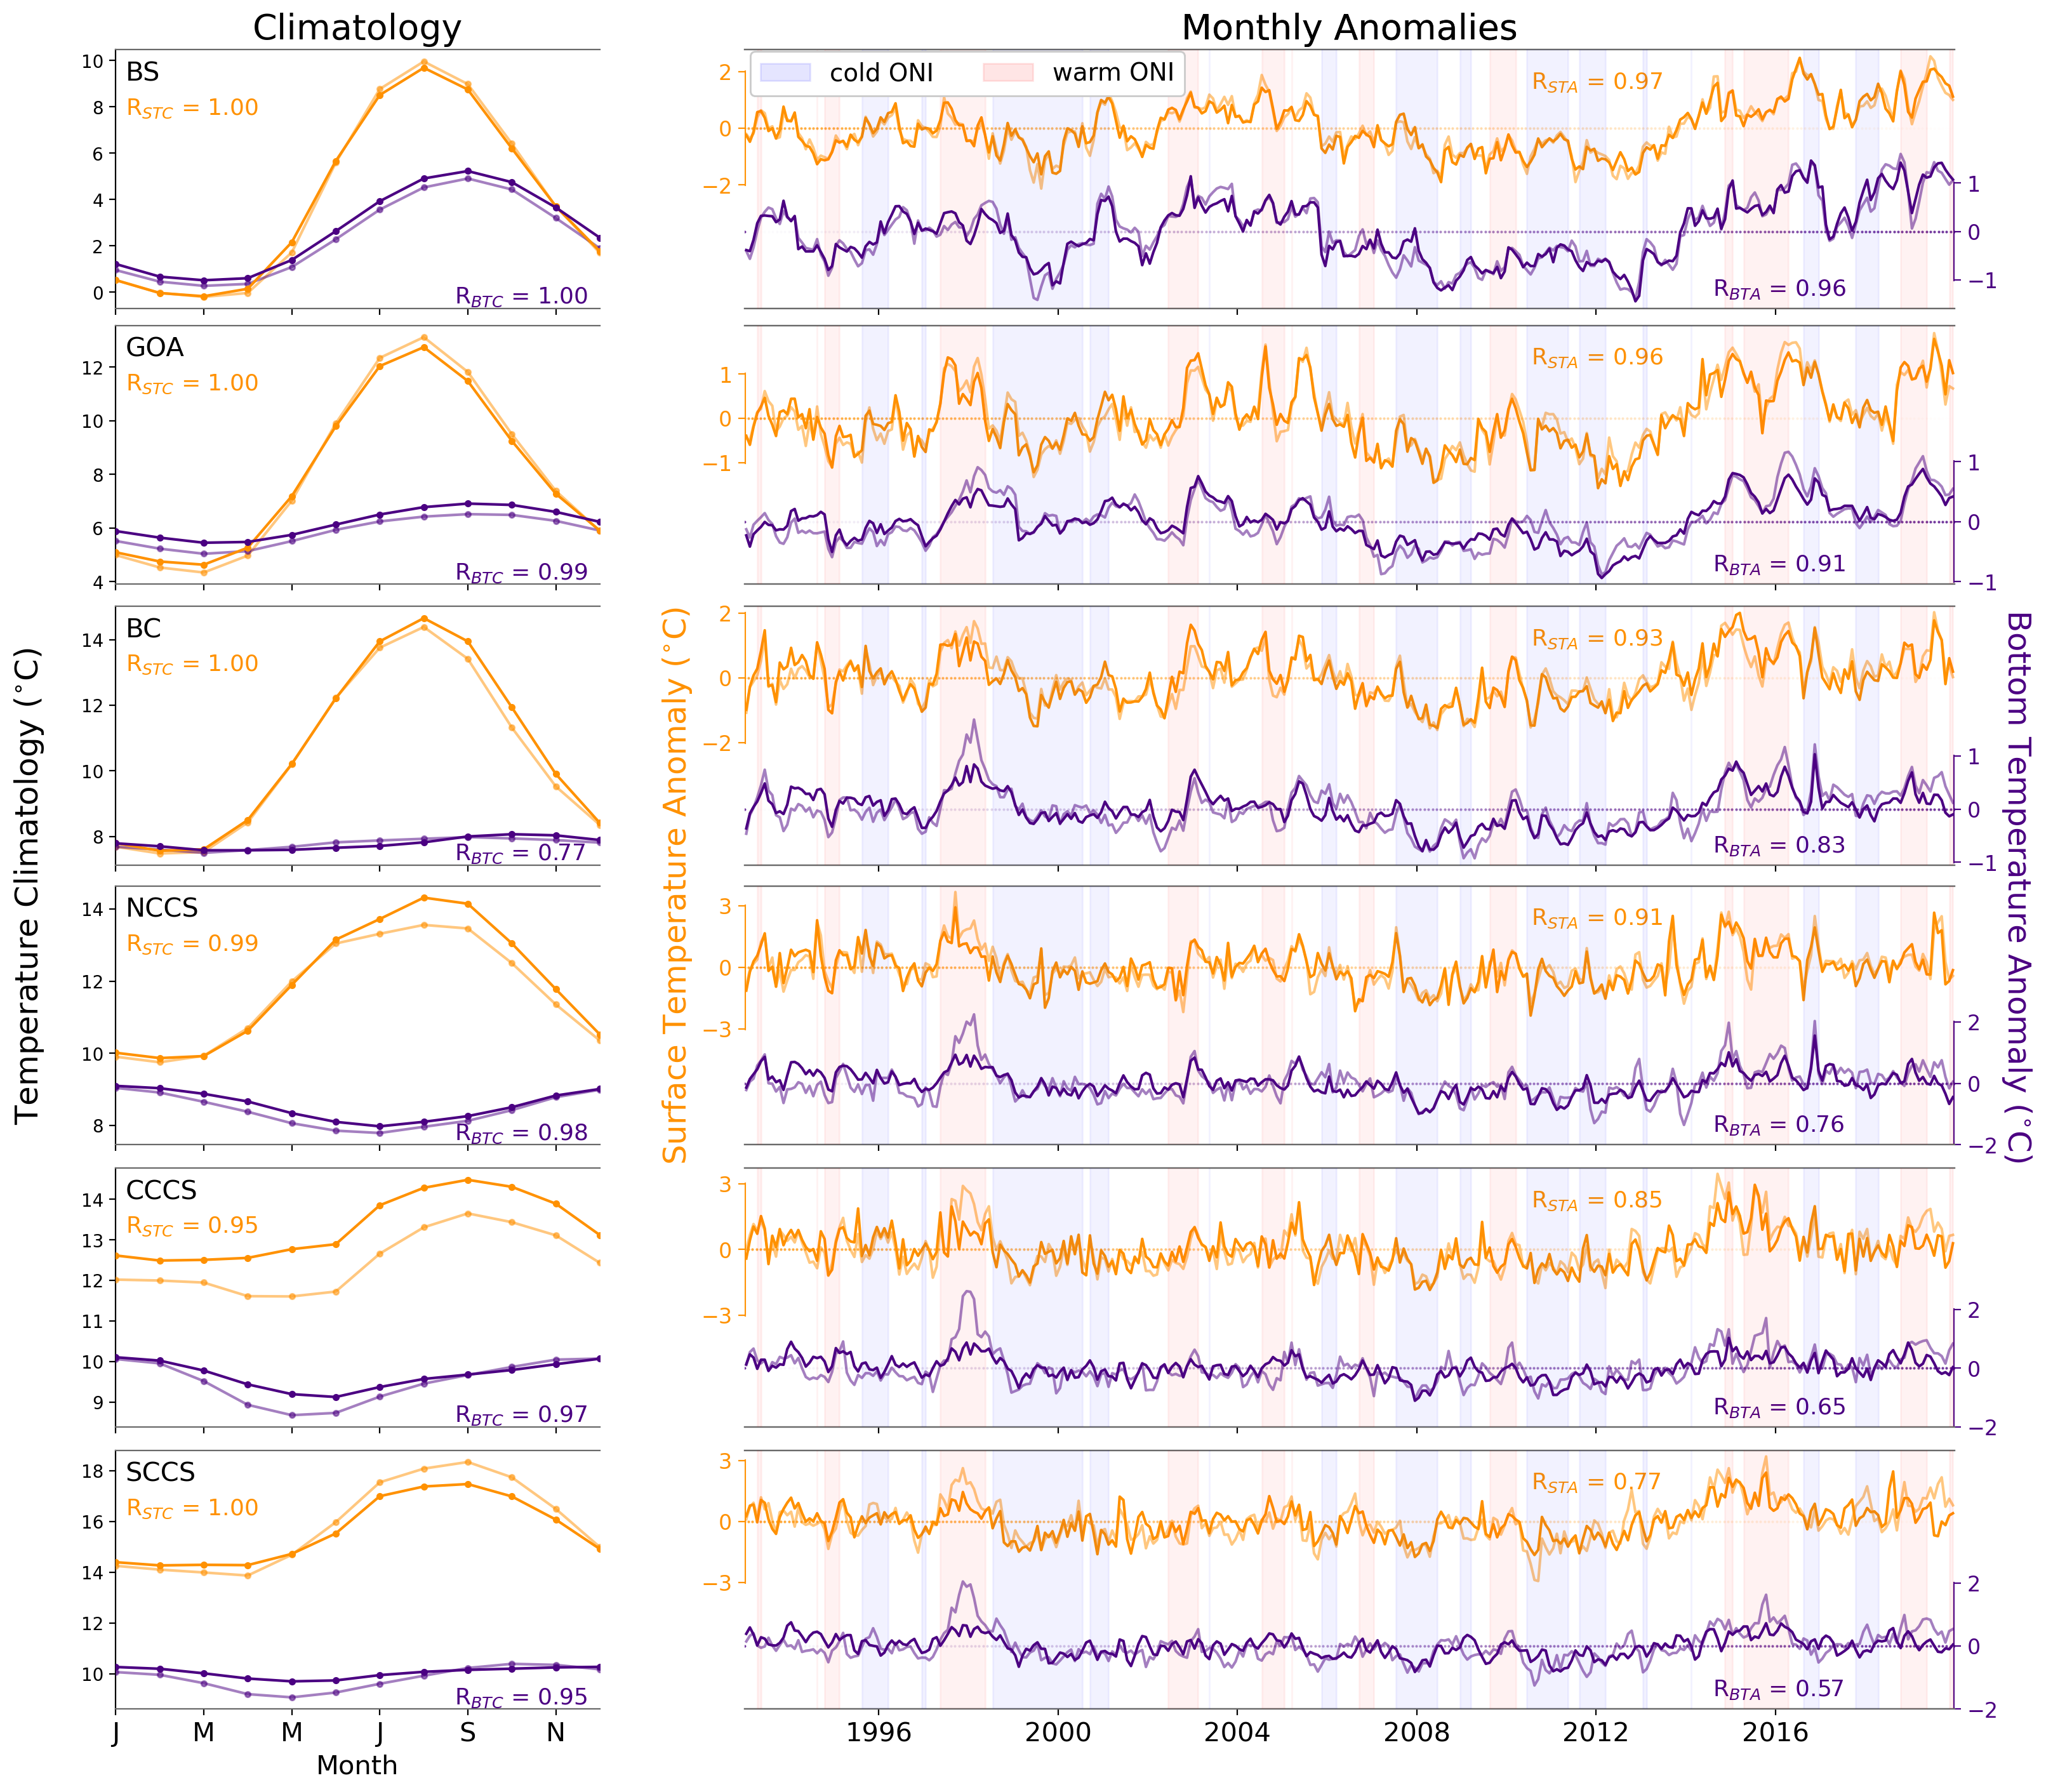

In [11]:
get_time = True

months = ['J','F','M','A','M','J','J','A','S','O','N','D']
regions = ['ber', 'goa', 'bc', 'nccs','cccs','sccs']
shelf_criteria_list = ['0-500m']
ts_type = 'anomaly'
scrit = '0-500m'
ncrit = 0

# Creating Figure objects
widths = [2, 5]
gs_kw = dict(width_ratios=widths, wspace=.06)
fig, axs1 = plt.subplots(ncols=2, nrows=6, constrained_layout=True, sharex='col', 
                        gridspec_kw=gs_kw, figsize=(16,14),dpi=200)

axs2 = np.array([axs1.ravel()[nax].twinx() for nax in np.arange(12)[1::2]]) 
nplot = 0
for depth_lev in ['surface','bottom']:     

    line_alpha = 1         
    for comp_mod in ['nep','glorys']:
        # assign fid and process the data
        ncfil = models_dict[comp_mod]['dir'] + models_dict[comp_mod][depth_lev]['fil']
        fid = nc.Dataset(ncfil)
            
        if comp_mod == 'nep':
            var_val = fid.variables[models_dict[comp_mod][depth_lev]['var']][:].squeeze()
        elif comp_mod == 'glorys':
            if depth_lev == 'surface':
                var_val = fid.variables[models_dict[comp_mod][depth_lev]['var']][:].squeeze()
            else:
                var_val = fid.variables[models_dict[comp_mod][depth_lev]['var']][:].squeeze()
            
        lat, lon, coors, depth, area = get_coords()
        depth_criteria = (depth<shelf_criteria[scrit]['dep_max'])*(depth>shelf_criteria[scrit]['dep_min'])
            
        if get_time:
            plt_time = convert_nep_time(fid.variables['time'][:])
            # storage variable for nep time series to compare against glorys; written over for each shelf criteria
            nep_ts_stor = np.zeros((len(regions),len(plt_time)))
            nep_clim_stor = np.zeros((len(regions),12))
            get_time = False
                
        if ts_type == 'anomaly':
            #print(var_val.shape)
            # caculate the anomaly
            var_clim = var_val.reshape((-1,12,var_val.shape[1],var_val.shape[2]))
            var_clim = np.mean(var_clim,axis=0)
            var_anom = var_val.reshape((-1,12,var_val.shape[1],var_val.shape[2])) - var_clim[np.newaxis,:]
            var_anom = var_anom.reshape(var_val.shape)
            # update var_val
            var_val = copy.deepcopy(var_anom)

        for region,nreg in zip(regions,range(len(regions))):
            print(region,nreg)
            # define regional values
            poly_path=Path(np.array(region_dict[region]['points']))
                    
            ##################### MAKE GENERIC FOR LOOP
            poly_mask = poly_path.contains_points(coors).reshape(var_val.shape[1],var_val.shape[2])
            region_mask = (poly_mask==1)*depth_criteria
            print(np.sum(region_mask))    
            tmp_area = np.ma.where(region_mask,area,np.nan)
            total_area = np.nansum(tmp_area)   
            area_weight = tmp_area/total_area
            
            tmp_clim = copy.deepcopy(var_clim)
            tmp_clim[:,~region_mask] = np.nan
            region_clim = np.nansum(area_weight*tmp_clim,axis=(2,1))
            
            tmp_val = copy.deepcopy(var_val)
            tmp_val[:,~region_mask] = np.nan
            region_ts = np.nansum(area_weight*tmp_val,axis=(2,1))
            #######################
            if comp_mod == 'nep':
                # store time series
                nep_clim_stor[nreg,:]=region_clim
                nep_ts_stor[nreg,:] = region_ts
                
            elif comp_mod == 'glorys': 
                # calculate the R value and store
                print(stats.pearsonr(nep_clim_stor[nreg,:], region_clim))
                print(np.mean(nep_clim_stor[nreg,:]-region_clim))
                print(stats.pearsonr(nep_ts_stor[nreg,:], region_ts))
            
            plot_clim(region_clim)
            nplot+=1
            plot_ts(plt_time,region_ts)
            nplot+=1
        line_alpha = line_alpha/2
        
# save figure object at this level
fig.subplots_adjust(wspace=0, hspace=0.05)
save_str = f'/work/Utheri.Wagura/NEP/plotting/Figure_17/{experiment}/Figure17_Regional_temperature_' + ts_type + '_' + scrit 
fig.savefig(save_str)
    